# Numerical integration: Interpolatory quadrature rules

As usual we start by importing the some standard boilerplate code.

In [1]:
%matplotlib inline

import numpy as np
from numpy import pi
from math import sqrt
from numpy.linalg import solve, norm    # Solve linear systems and compute norms
import matplotlib.pyplot as plt
import matplotlib.cm as cm

newparams = {'figure.figsize': (10.0, 10.0), 
             'axes.grid': True,
             'lines.markersize': 8, 
             'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)


## Introduction
Imagine you want to compute the finite integral

$$
I[f](a,b) = \int_a^b f(x) {\,\mathrm{d}x}.
$$

The "usual" way is to find a primitive function $F$
(also known as the indefinite integral of $f$)
satisfying $F'(x) = f(x)$ and then to compute

$$
\int_a^b f(x) {\,\mathrm{d}x} = F(b) - F(a).
$$

While there are many analytical integration techniques and extensive
tables to determine definite integral for many integrands,
more often than not it may not feasible or possible to compute the
integral. For instance, what about

$$
f(x) = \dfrac{\log(2 + \sin(1/2 - \sqrt(x))^6)}{\log(\pi + \arctan(\sqrt{1-\exp(-2x-\sin(x)))}}?
$$

Finding the corresponding primitive is highly likely a hopeless
endeavor. And sometimes even innocent looking functions
like $e^{-x^2}$ for which there is not primitive functions which
can expressed as a composition of standard functions such
as $\sin, \cos.$ etc.

A **numerical quadrature** or a **quadrature rule** is a formula for
approximating such definite integrals $I[f](a,b)$.  Quadrature rules
are usually of the form

<font color=LightSkyBlue>

$$
Q[f](a,b) = \sum_{i=0}^n w_i f(x_i),
$$

</font>

where $x_i$, $w_i$ for $i=0,1,\dotsc,n$ are respectively the *nodes/points*
and the *weights* of the quadrature rule.

To emphasize that a quadrature rule is defined by some given quadrature points
$\{x_i\}_{i=0}^n$ and weights $\{w_i\}_{i=0}^n$, we sometimes might write

$$
Q[f](
\{x_i\}_{i=0}^n,\{w_i\}_{i=0}^n
) = \sum_{i=0}^n w_i f(x_i).
$$


If the function $f$ is given from the context, we will for simplicity
denote the integral and the quadrature simply as $I(a,b)$ and
$Q(a,b)$.

The [trapezoidal rule, the midpoint rule and Simpson's rule](https://wiki.math.ntnu.no/tma4100/tema/numerics?&#numerisk_integrasjon)
known from previous courses are all examples of numerical quadratures,
and we quickly review them here, in addition to the very simple (and less accurate) left and right endpoint rules.

In [2]:
colors = plt.get_cmap("Pastel1").colors

def plot_qr_examples():
    f = lambda x : np.exp(x)
    fig, axs = plt.subplots(2,2)
    fig.set_figheight(8)
    # fig.set_figwidth(8)
    fig.set_figwidth(fig.get_size_inches()[0]*1.5)
    #axs[0].add_axes([0.1, 0.2, 0.8, 0.7])
    a, b = -0.5,0.5
    l, r = -1.0, 1.0
    x_a = np.linspace(a, b, 100)

    for raxs in axs:
        for ax in raxs:
            ax.set_xlim(l, r)
            x = np.linspace(l, r, 100)
            ax.plot(x, f(x), "k--", label="$f(x)$")
            ax.fill_between(x_a, f(x_a), alpha=0.1, color='k')
            ax.xaxis.set_ticks_position('bottom')
            ax.set_xticks([a,b])
            ax.set_xticklabels(["$a$", "$b$"])
            ax.set_yticks([])
            ax.legend(loc="upper center")

    # Left endpoint rule
    axs[0,0].bar(a, f(a), b-a, align='edge', color=colors[0])
    axs[0,0].plot(a,f(a), 'ko', markersize="12")
    axs[0,0].set_title("Left endpoint rule")
    axs[0,0].annotate('$f(a)$', 
             xy=(a, f(a)), xytext=(-10, 10), 
             textcoords="offset points")

    # Right endpoint rule
    axs[0,1].bar(a, f(b), b-a, align='edge',  color=colors[1])
    axs[0,1].plot(b,f(b), 'ko', markersize="15")
    axs[0,1].set_title("Right endpoint rule")
    axs[0,1].annotate('$f(b)$', 
             xy=(b, f(b)), xytext=(-10, 10), 
             textcoords="offset points")
    # Midpoint rule
    axs[1,0].bar(a, f((a+b)/2), b-a, align='edge', color=colors[2])
    axs[1,0].plot((a+b)/2,f((a+b)/2), 'ko', markersize="15")
    axs[1,0].set_title("Midpoint rule")
    axs[1,0].annotate('$f((a+b)/2))$', 
             xy=((a+b)/2, f((a+b)/2)), xytext=(-10, 10), 
             textcoords="offset points")

    # Trapezoidal rule
    axs[1,1].set_title("Trapezoidal rule")
    axs[1,1].fill_between([a,b], [f(a), f(b)], alpha=0.8, color=colors[4])
    axs[1,1].plot([a,b],f([a,b]), 'ko', markersize="15")
    axs[1,1].annotate('$f(a)$', 
             xy=(a, f(a)), xytext=(-10, 10), 
             textcoords="offset points")
    axs[1,1].annotate('$f(b)$', 
             xy=(b, f(b)), xytext=(-10, 10), 
             textcoords="offset points")
    axs[1,1].annotate('$f(b)$', 
             xy=(b, f(b)), xytext=(-10, 10), 
             textcoords="offset points")
    

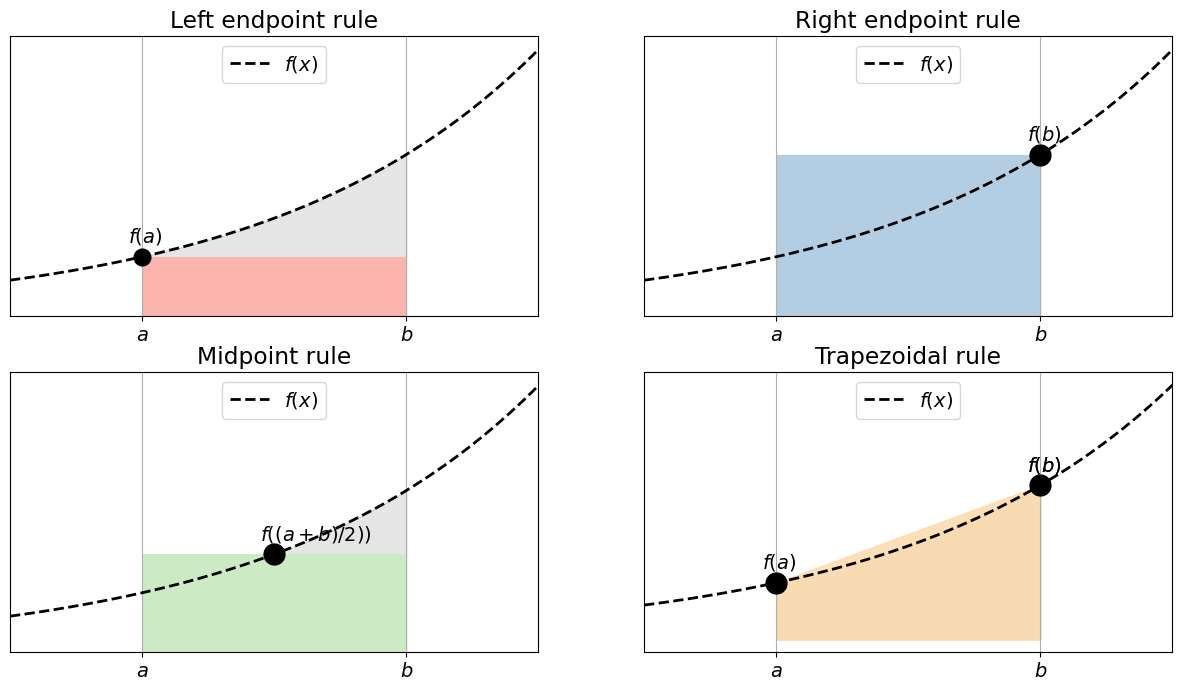

In [3]:
plot_qr_examples()


* **Left and right endpoint rule** are among the simplest possible quadrature rule defined by

$$
QL[f](a,b) := f(a)(b-a) \quad \text{and } \quad QR[f](a,b) := f(b)(b-a)
$$

respectively. The (single) quadrature point for $QL[\cdot]$ and $QR[\cdot]$ is given by $x_0 = a$ and $x_0 = b$ respectively, and both use the corresponding
weight $w_0 = b-a$.

* **Midpoint rule** is the quadrature rule defined by

$$
Q[f](a,b) := (b-a) f\left(\frac{a+b}{2}\right).
$$

The node is given by the midpoint, $x_0 = \tfrac{a+b}{2}$ with the corresponding
weight $w_0 = b-a$.

$$
Q[f](a,b) = w_0 f(x_0)
$$

* **Trapezoidal rule** is given by

$$
Q[f](a,b) := (b-a)\left(\frac{f(a)+f(b)}{2}\right)
$$

<font color = green>

$ = \frac{b-a}{2} (f(a) + f(b)) $

</font>

and thus the nodes are defined by $x_0 = a$, $x_1 = b$ with corresponding
weights $w_0 = w_1 = \tfrac{b-a}{2}$.

* Finally, **Simpson's rule** which you know from Matte 1, is defined as follows:

$$
Q[f](a,b)=\frac{b-a}{6}\left( f(a)+4f\left( \frac{a+b}{2}\right) + f(b)\right),
$$

which we identify as quadrature rule with 3 points $x_0 = a, x_1 = \tfrac{a+b}{2},
x_2 = b$ and corresponding weights $w_0 = w_2 = \tfrac{b-a}{6}$ and $w_1 = \tfrac{4(b-a)}{6}$.

In this note we will see how quadrature rules can be constructed from
integration of interpolation polynomials.  We will demonstrate how to
do error analysis and how to find error estimates.

## Quadrature based on polynomial interpolation.
This section relies on the content of the note on polynomial
interpolation, in particular the section on Lagrange polynomials.

Choose $n+1$ distinct nodes $x_i$, $i=0,\dotsc,n$ in the interval $[a,b]$, and let $p_n(x)$ be the interpolation polynomial satisfying
the interpolation condition

$$
p_n(x_i) = f(x_i), \qquad i=0,1,\ldots n.
$$

We will then use $\int_a^b p_n(x){\,\mathrm{d}x}$ as an approximation to $\int_a^b
f(x){\,\mathrm{d}x}$. By using the Lagrange form of the polynomial

$$
p_n(x) = \sum_{i=0}^n f(x_i) \ell_i(x)
$$

with the cardinal functions $\ell_i(x)$ given by

$$
\ell_i(x) = \prod_{j=0,j\not=i}^n \frac{x-x_j}{x_i-x_j},
$$

the following quadrature formula is obtained

\begin{align*}
I[f](a, b)
\approx
Q[f](a,b) &= \int_a^b p_n(x){\,\mathrm{d}x}
  \\
  &= \sum_{i=0}^n f(x_i) \int_a^b \ell_i(x) {\,\mathrm{d}x} 
  = \sum_{i=0}^n w_i f(x_i) = Q(a,b),
\end{align*}

where the weights in the quadrature are simply the integral of the
cardinal functions over the interval

$$
w_i =\int_a^b \ell_i(x) {\,\mathrm{d}x} \quad \text{for } i = 0, \ldots, n.
$$

Let us derive three schemes for integration over the interval $[0,1]$,
which we will finally apply to the integral

$$
I(0,1) = \int_0^1 \cos\left(\frac{\pi}{2}x\right) = \frac{2}{\pi} = 0.636619\dotsc.
$$

Eksempel - The trapezoidal rule revisited:

Let $x_0=0$ and $x_1=1$. The cardinal functions and thus the weights are given by

\begin{align*}
\ell_0(x) &= 1-x, & w_0 &= \int_0^1(1-x){\,\mathrm{d}x} = 1/2  \\ 
\ell_1(x) &= x,   & w_1 &= \int_0^1 x{\,\mathrm{d}x} = 1/2
\end{align*}


and the corresponding quadrature rule is the trapezoidal rule (usually
denoted by $T$) with $[a,b] = [0,1]$:

$$
\mathrm{T}[f](0,1) = \frac{1}{2} \left[ f(0) + f(1) \right].
$$

Eksempel - Gauß-Legendre quadrature for $n=2$:

Let $x_0=1/2 + \sqrt{3}/6$ and $x_1 = 1/2 - \sqrt{3}/6$. Then

\begin{align*}
\ell_0(x) &= -\sqrt{3}x + \frac{1+\sqrt{3}}{2}, & w_0 &= \int_0^1 \ell_0(x){\,\mathrm{d}x}=  1/2,  \\ 
\ell_1(x) &=  \sqrt{3}x + \frac{1-\sqrt{3}}{2}, & w_1 &= \int_0^1 \ell_1(x){\,\mathrm{d}x} = 1/2.
\end{align*}

The quadrature rule is

$$
\mathrm{GL}[f](0,1) = \frac{1}{2}\left[f\left(\frac{1}{2}-\frac{\sqrt{3}}{6}\right) + 
f\left(\frac{1}{2}+\frac{\sqrt{3}}{6}\right) \right].
$$

Eksempel - Simpson's rule revisited:

We construct Simpson's rule on the interval $[0,1]$ by choosing
the nodes $x_0=0$, $x_1=0.5$ and $x_2=1$. 
The corresponding cardinal
functions are

$$
\ell_0 = 2(x - 0.5)(x-1)
\qquad
\ell_1(x) = 4x(1-x)
\qquad
\ell_2(x) = 2x(x-0.5)
$$

which gives the weights

$$
w_0 = \int_{0}^1 \ell_0(x){\,\mathrm{d}x} = \frac{1}{6}, \qquad
w_1 = \int_{0}^1 \ell_1(x){\,\mathrm{d}x} = \frac{4}{6}, \qquad
w_2 = \int_{0}^1 \ell_2(x){\,\mathrm{d}x} = \frac{1}{6}
$$

such that

$$
% \int_{0}^1 f(x) {\,\mathrm{d}x} \approx \int_{0}^1 p_2(x) {\,\mathrm{d}x}
%=
\mathrm{S}[F](0,1)
:= \sum_{i=0}^2 w_i f(x_i) = \frac{1}{6} \left[\; f(0) + 4 f(0.5) + f(1) \; \right].
$$

Oppgave - Accuracy of some quadrature rules:

Use the `QR` function below to compute an approximate value of integral for $f(x)= \cos\left(\frac{\pi}{2}x\right)$

$$
I[f](0,1) = \int_0^1 \cos\left(\frac{\pi}{2}x\right) = \frac{2}{\pi} = 0.636619\dotsc.
$$

using the quadrature rules just revised.
Tabulate the corresponding quadrature errors $I[f](0,1) - Q[f](0,1)$.

<font color=green>

### Implementation

</font>

In [4]:
def QR(f, xq, wq):
    """ Computes an approximation of the integral f
    for a given quadrature rule.
    
    Input:
        f:  integrand
        xq: list of quadrature nodes
        wq: list of quadrature weights
    """
    n = len(xq)
    if (n != len(wq)):
        raise RuntimeError("Error: Need same number of quadrature nodes and weights!")
    return np.array(wq)@f(np.array(xq))


In [14]:
# Define function
def f(x):
    return np.cos(np.pi/2 * x)

# Exact integral
int_f = 2/pi

print("I[f] = {:.10e}".format(int_f))
print("\n")

# Trapezoidal rule
xq = [0, 1]
wq = [1/2, 1/2]

qr_f = QR(f, xq, wq)
print("Trapezoidal rule:")
print("Q[f] = {}".format(qr_f))
print("I[f] - Q[f] = {:.10e}".format(int_f - qr_f))
print("\n")

# Gauß-Legendre rule
xq = [1/2 + sqrt(3)/6, 1/2 - sqrt(3)/6]
wq = [1/2, 1/2]

qr_f = QR(f, xq, wq)
print("Gauß-Legendre rule:")
print("Q[f] = {}".format(qr_f))
print("I[f] - Q[f] = {:.10e}".format(int_f - qr_f))
print("\n")

# Simpson's rule
xq = [0, 1/2, 1]
wq = [1/6, 4/6, 1/6]

qr_f = QR(f, xq, wq)
print("Simpson's rule:")
print("Q[f] = {}".format(qr_f))
print("I[f] - Q[f] = {:.10e}".format(int_f - qr_f))
print("\n")


I[f] = 6.3661977237e-01


Trapezoidal rule:
Q[f] = 0.5
I[f] - Q[f] = 1.3661977237e-01


Gauß-Legendre rule:
Q[f] = 0.6356474078605917
I[f] - Q[f] = 9.7236450699e-04


Simpson's rule:
Q[f] = 0.6380711874576983
I[f] - Q[f] = -1.4514150901e-03




We observe that with the same number of quadrature points,
the Gauß-Legendre quadrature gives a much more accurate answer
then the trapezoidal rule. So the choice of nodes clearly matters.
Simpon's rule gives very similar results
to Gauß-Legendre quadrature, but it uses 3 instead of 2 quadrature nodes.
The quadrature rules which based on polynomial interpolation
and *equidistributed quadrature nodes* go under the
name **Newton Cotes formulas** (see below).

## Degree of exactness and an estimate of the quadrature error
Motivated by the previous examples, we now take a closer look at how to
assess the quality of a method. We start with the following definition.

Definisjon - The degree of exactness (presisjonsgrad):

<font color = Orchid>

A numerical quadrature has degree of exactness $d$ if $Q[p](a,b) =
I[p](a,b)$ for all $p \in \mathbb{P}_d$ and there is at least one
$p\in \mathbb{P}_{d+1}$ such that $Q[p](a,b) \not= I[p](a,b)$.

</font>

Since both integrals and quadratures are linear in the integrand $f$,
the degree of exactness is $d$ if

\begin{align*}
I[x^j](a,b) &= Q[x^j](a,b), \qquad j=0,1,\dotsc, d, \\ 
I[x^{d+1}](a,b) &\not= Q[x^{d+1}](a,b).
\end{align*}

<font color=Orchid>All quadratures constructed from Lagrange interpolation polynomials in
$n+1$ distinct nodes will automatically have a degree of exactness of **at least** $n$.</font>
This follows immediately from the fact the interpolation polynomial
$p_n \in \mathbb{P}_n$ of any polynomial $q \in \mathbb{P}_n$ is just the original
polynomial $q$ itself. But sometimes the degree of exactness can be even higher
as the next exercise shows!

Oppgave - Degree of exactness for some quadrature rules:

* What is the degree of exactness for the left and right endpoint rule from `exa-known-qr-rules`?

* What is the degree of exactness for the trapezoidal and midpoint rule from `exa-known-qr-rules`?

* What is the degree of exactness for Gauß-Legendre quadrature for 2 points from `exa:gauss-legend-quad`?

* What is the degree of exactness for Simpson's rule from `exa-simpson-rule`?

We test the degree of exactness for each of theses quadratures by
  * computing the exact integral $I[x^n](0,1) = \int_0^1 x^n dx$ for let's say $n=0,1,2,3,4$
  * computing the corresponding numerical integral $Q[x^n](0,1)$ using the given quadrature rule.
  * look at the difference $I[x^n](0,1) - Q[x^n](0,1)$ for each of the quadrature rules.
  
You can start from the code outline below.

$$
EL[f](0, 1) = 1 \cdot f(0), \quad ER[f](0, 1) = 1 \cdot f(1),
$$

$$
M[f](0,1)= 1 \cdot f(\tfrac{1}{2}), \quad T[f](0,1) = \frac{1}{2} \left[f(0) + f(1) \right].
$$

$$
GL(0,1) = \frac{1}{2}\left[f\left(\frac{1}{2}-\frac{\sqrt{3}}{6}\right) + 
f\left(\frac{1}{2}+\frac{\sqrt{3}}{6}\right) \right],
\quad S(0,1) = \frac{1}{6} \left[f(0) + 4 f(0.5) + f(1) \right].
$$

In [19]:
from collections import namedtuple
qr_tuple = namedtuple("qr_tuple", ["name", "xq", "wq"])

quadrature_rules =  [
    qr_tuple(name = "left endpoint rule", xq=[0], wq=[1]), 
    qr_tuple(name = "right endpoint rule", xq=[1], wq=[1]),
    qr_tuple(name = "trapezoidal rule", xq=[0, 1], wq=[1/2, 1/2]),
    qr_tuple(name = "midpoint rule", xq=[1/2], wq=[1]),
    qr_tuple(name = "Gauß-Legendre rule", xq=[1/2 + sqrt(3)/6, 1/2 - sqrt(3)/6], wq=[1/2, 1/2]),
    qr_tuple(name = "Simpson's rule", xq=[0, 1/2, 1], wq=[1/6, 4/6, 1/6])
]

# n defines maximal monomial powers you want to test
for n in range(5):
    
    print("===========================================")
    print(f"Testing degree of exactness for n = {n}")

    # Define function
    def f(x):
        return x**n

    # Exact integral
    int_f = 1./(n+1)

    for qr in quadrature_rules:
        print("-------------------------------------------")
        print(f"Testing {qr.name}")

        qr_f = QR(f, qr.xq, qr.wq)
        print(f"Q[f] = {qr_f}")
        print(f"I[f] - Q[f] = {int_f - qr_f:.16e}")


Testing degree of exactness for n = 0
-------------------------------------------
Testing left endpoint rule
Q[f] = 1
I[f] - Q[f] = 0.0000000000000000e+00
-------------------------------------------
Testing right endpoint rule
Q[f] = 1
I[f] - Q[f] = 0.0000000000000000e+00
-------------------------------------------
Testing trapezoidal rule
Q[f] = 1.0
I[f] - Q[f] = 0.0000000000000000e+00
-------------------------------------------
Testing midpoint rule
Q[f] = 1.0
I[f] - Q[f] = 0.0000000000000000e+00
-------------------------------------------
Testing Gauß-Legendre rule
Q[f] = 1.0
I[f] - Q[f] = 0.0000000000000000e+00
-------------------------------------------
Testing Simpson's rule
Q[f] = 0.9999999999999999
I[f] - Q[f] = 1.1102230246251565e-16
Testing degree of exactness for n = 1
-------------------------------------------
Testing left endpoint rule
Q[f] = 0
I[f] - Q[f] = 5.0000000000000000e-01
-------------------------------------------
Testing right endpoint rule
Q[f] = 1
I[f] - Q[f]

Left endpoint rule: d = 0

Right endpoint rule: d = 0

Trapezoidal rule: d = 1

Midpoint rule: d = 1

Gauß-Legendre rule: d = 3 (feilen på 2.7755575615628914e-17 er numerisk avrundingsfeil, er i praksis 0)

Simpson's rule: d = 3

## Estimates for the quadrature error

Teorem - Error estimate for quadrature rule with degree of exactness $n$:

Assume that $f \in C^{n+1}(a,b)$ and
let $Q[\cdot](\{x_i\}_{i=0}^n, \{w_i\}_{i=0}^n)$
be a quadrature rule which has degree of exactness
$n$.
Then the quadrature error  $|I[f]-Q[f]|$ can be estimated by

<font color=LightSkyBlue>

$$
|I[f]-Q[f]| \leqslant \frac{M}{(n+1)!}\int_a^b \prod_{i=0}^n |x-x_i|{\,\mathrm{d}x}
$$

</font>

where $M=\max_{\xi \in [a,b]} |f^{n+1}(\xi)|$.

Bevis:
Let $p_n \in \mathbb{P}_n$ be the interpolation polynomial satisfying
$p_n(x_i) = f(x_i)$ for $i=0,\ldots,n$.
Thanks to the error estimate for the interpolation error, we know that

$$
f(x)-p_n(x)=\frac{f^{n+1}(\xi(x))}{(n+1)!}\prod_{k=0}^{n}(x-x_{k}).
$$

for some $\xi(x) \in (a,b)$.
Since $Q(a,b)$ has degree of exactness $n$ we have $I[p_n] = Q[p_n] = Q[f]$
and thus


\begin{align*}
|I[f]-Q[f]|
=
|I[f]-I[p_n]|
&\leqslant
\int_a^b
|f(x)-p_n(x)| {\,\mathrm{d}x}
\\ 
&=
\int_a^b
\Biggl|
\frac{f^{n+1}(\xi(x))}{(n+1)!}\prod_{k=0}^{n}(x-x_{k})
\Biggr| {\,\mathrm{d}x}
\\
&\leqslant
\frac{M}{(n+1)!}
\int_a^b
\prod_{k=0}^{n}|(x-x_{k})|
{\,\mathrm{d}x},
\end{align*}

which concludes the proof.

The advantage of the previous theorem is
that it is easy to prove.
On downside is that the provided estimate can be rather
crude, and often sharper estimates can be established.
We give two examples here of some sharper estimates
(but without proof).

Teorem - Error estimate for the trapezoidal rule:

For the trapezoidal rule, there is a $\xi \in (a,b)$ such that

<font color=LightSkyBlue>

$$
I[f]-Q[f]=\frac{(b-a)^3}{12}f''(\xi).
$$

</font>

Teorem - Error estimate for Simpson's rule:

For Simpson's rule, there is a $\xi \in (a,b)$ such that

<font color=LightSkyBlue>

$$
I[f]-Q[f]=-\frac{(b-a)^5}{2880} f^4(\xi).
$$

</font>

## Newton-Cotes formulas

We have already seen that *given* $n+1$ distinct but
otherwise arbitrary quadrature
nodes $\{x_i\}_{i=0}^n \subset [a,b]$, we can construct
a quadrature rule
$
\mathrm{Q}[\cdot](\{x_i\}_{i=0}^{n+1},\{w_i\}_{i=0}^{n+1})
$
based on polynomial interpolation
which has degree of exactness equals to $n$.

An classical example was the trapezoidal rule,
which are based on the
two quadrature points $x_0=a$ and $x_1=b$
and which has degree of exactness equal
to $1$.

The trapezoidal is the simplest example of a quadrature formula 
which belongs to the so-called **Newton Cotes formulas**.

<font color=Orchid>By definition, **Newton-Cotes formulas** are quadrature rules
which are based on **equidistributed nodes**
$\{x_i\}_{i=0}^n \subset [a,b]$
and have degree of exactness equals to $n$.</font>

The simplest choices here --- the
*closed* Newton-Cotes methods --- use the nodes
$x_i = a + ih$ with $h = (b-a)/n$. Examples of these are the Trapezoidal rule and Simpson's rule.
The main appeal of these rules is the simple definition of the nodes.

<font color=Orchid>

If $n$ is odd, the Newton-Cotes method with $n+1$ nodes has degree of precision $n$;
if $n$ is even, it has degree of precision $n+1$. The corresponding convergence order
for the composite rule is, as for all such rules, one larger than the degree of precision,
provided that the function $f$ is sufficiently smooth.

</font>

However, for $n \ge 8$ negative weights begin to appear in the definitions.
Note that for a positive function $f(x) \geqslant 0$
we have that the integral $I[f](a,b) \geqslant 0$
But for a quadrature rule with negative weights 
**we have not necessarily that $Q[f](a,b) \geqslant 0$!**
This has the undesired effect that the numerical integral of a positive function
can be negative. 

In addition, this can lead to cancellation errors in the
numerical evaluation, which may result in a lower practical accuracy.
Since the rules with $n=6$ and $n=7$ yield the same convergence order,
this mean that it is mostly the rules with $n \le 6$ that are used in practice.

The *open* Newton-Cotes methods, in contrast, use the nodes 
$x_i = a + (i+1/2)h$ with $h = (b-a)/(n+1)$. The simplest example here
is the midpoint rule.
Here negative weights appear already for $n \ge 2$. Thus the midpoint rule
is the only such rule that is commonly used in applications.